Dataset: https://gianmarco.com.ar/blog/es/blog/silkroad2

**Tarea 3: Regresión sobre el precio del ítem**

¿Se puede predecir el precio del ítem en base a su información? 

¿Qué tan bien funciona en validación? 

¿Qué tan bien funciona años después en versus?


In [ ]:
pip install --upgrade category_encoders

In [ ]:
import pandas as pd
import numpy as np
import pickle
from sklearn import linear_model
from sklearn.metrics import mean_squared_error, r2_score
import category_encoders as ce

import matplotlib.pyplot as plt
from matplotlib import style
import seaborn as sns


from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# Authenticate and create the PyDrive client
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

In [ ]:
downloaded = drive.CreateFile({'id': '1lHuzdCSh7dW_8dmd6tgLge1_mWHqJ5xs'})
downloaded.GetContentFile('silkroad_items.csv')

In [ ]:
downloaded = drive.CreateFile({'id': '1YKEWXsQu2fJEFxhJtVEWVg6gM53ZyUX2'})
downloaded.GetContentFile('Bitcoin2014-2015.csv')

In [ ]:
items = pd.read_csv('silkroad_items.csv', encoding='latin-1')
items["timestamp"]=pd.to_datetime(items["timestamp"])
items["timestamp"] = items['timestamp'].dt.floor('d')

Hay varios features distintos entre el dataset y versus, como voy a tener que usar el mismo modelo para la regresión de ambos. Voy a quedarme con los datos que comparten.

Elimino columnas que no me sirven:

In [ ]:
items.drop(['image_id', 'original_path', 'description', 'ships_to', 'vendor', 'item_id'], axis = 1, inplace=True)

In [ ]:
items.head()

,title,price,category,timestamp,ships_from
0,JJ Luna privacy ebooks,0.001722,Alcohol,2014-02-23,Undeclared
1,The Morality of Capitalism,0.003443,Alcohol,2014-02-23,Undeclared
2,Survive!,0.001722,Alcohol,2014-02-23,Undeclared
3,A Non-Religious New Testament,0.015496,Alcohol,2014-02-23,Undeclared
4,Mindless Slogans: 101 Cheap Substitutes for Ac...,0.001722,Alcohol,2014-02-23,Undeclared


En versus tengo los precios en Euros, así que voy a calcular los precios de los items en euros según fecha y cotización del btc

Precios de BTC en euros, los saque de: https://www.investing.com/crypto/bitcoin/historical-data?cid=1057388

In [ ]:
btc = pd.read_csv('Bitcoin2014-2015.csv', encoding='latin-1')
btc.rename(columns={'ï»¿"Date"':'Date'}, inplace=True)
btc['Date'] = pd.to_datetime(btc['Date'])
btc = btc.drop(['Open', 'High', 'Low', 'Vol.', 'Change %'], axis=1)
btc.head()

,Date,Price
0,2015-02-01,200.8
1,2015-01-31,194.2
2,2015-01-30,206.0
3,2015-01-29,206.2
4,2015-01-28,212.5


In [ ]:
items = items.merge(btc, left_on='timestamp', right_on='Date', how='left')
btc = None
items.head(3)

,title,price,category,timestamp,ships_from,Date,Price
0,JJ Luna privacy ebooks,0.001722,Alcohol,2014-02-23,Undeclared,2014-02-23,272.6
1,The Morality of Capitalism,0.003443,Alcohol,2014-02-23,Undeclared,2014-02-23,272.6
2,Survive!,0.001722,Alcohol,2014-02-23,Undeclared,2014-02-23,272.6


Hay algunos precios que son ridiculos (spoiler del canal de consultas). 
Así que directamente los borro.

Hay precios (btc) que estan como x.xxxe+xx, me voy a quedar con los que sean e+00 para abajo.

In [ ]:
items = items.sort_values(['price'], ascending = False).reset_index().drop(range(0,11900))

In [ ]:
items = items.reset_index()
items.drop(['index', 'level_0'], axis=1, inplace=True)

El precio que voy a predecir sera en euros, así que calculo BTC*EUROS:

In [ ]:
items.drop(['Date'], axis=1, inplace=True)

items['Price_EUR'] = items['price'] * items['Price']
items.drop(['Price', 'price'], axis=1, inplace=True)
items.head(5)

,title,category,timestamp,ships_from,Price_EUR
0,1000 grams of pure butylone (bk-MBDB),Ecstasy,2014-10-25,China,2758.427798
1,4-FMA - 1000g,FMA's,2014-10-25,China,2758.427798
2,THJ-2201 - 1000g,Chemicals,2014-09-15,China,3623.646734
3,Drostanolone enanthate - 250g,Drostanolone,2014-06-10,China,4765.330148
4,Drostanolone Propionate - 250g,Drostanolone,2014-06-10,China,4765.330148


In [ ]:
items['Price_EUR'].max()

4765.3301484

Veo si hay productos con NaN, de ser así los borro.

In [ ]:
items['Price_EUR'].isnull().values.sum()

64

In [ ]:
items.dropna(subset=['Price_EUR'], inplace=True)

Ordeno cronologicamente:

In [ ]:
items = items.sort_values(["timestamp"])

Voy a separar en train(80%) y validación(20%).

Tengo 389130 entradas, el 80% sería: 311304

In [ ]:
train = items.iloc[:311304]

validation = items.iloc[311304:]

items = None

Voy a dividir las fechas en 3 columnas: año, mes, dia.

In [ ]:
train['Year'] = train['timestamp'].dt.year 
train['Month'] = train['timestamp'].dt.month
train['Day'] = train['timestamp'].dt.day 

train.drop('timestamp', axis=1, inplace=True)

validation['Year'] = validation['timestamp'].dt.year 
validation['Month'] = validation['timestamp'].dt.month
validation['Day'] = validation['timestamp'].dt.day 


validation.drop('timestamp', axis=1, inplace=True)

**Tema: NaN**

Si son de features numericos: no hay

Si son de features no numericos: pasaran a ser el valor 'Desconocido' (pasa a ser una categoría del feature)

In [ ]:
train.fillna('Desconocido', inplace=True)
validation.fillna('Desconocido', inplace=True)

# Encodings:

**OHE**

Se lo voy a aplicar a ships_from. Me voy a quedar con el top 25 y el resto los agrupo en "Otros"

In [ ]:
ships_from = train['ships_from'].value_counts().to_frame().head(25).index
train.loc[~train['ships_from'].isin(ships_from), 'ships_from'] = 'Otros'
validation.loc[~validation['ships_from'].isin(ships_from), 'ships_from'] = 'Otros'

In [ ]:
ohe = pd.get_dummies(train['ships_from'], prefix='From', drop_first = False, dummy_na = True)
ohe.head()

,From_Armenia,From_Australia,From_Belgium,From_Bulgaria,From_Canada,From_China,From_Czech Republic,From_Denmark,From_France,From_Germany,"From_Hong Kong, (China)",From_Hungary,From_India,From_Ireland,From_Netherlands,From_New Zealand,From_Norway,From_Otros,From_Slovakia,From_South Africa,From_Spain,From_Sweden,From_Switzerland,From_Undeclared,From_United Kingdom,From_United States,From_nan
153133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0
364041,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
169777,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
221483,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
338625,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0


In [ ]:
train.drop(['ships_from'], axis = 1, inplace = True)
train = pd.concat([train, ohe], axis = 1)

In [ ]:
ohe2 = pd.get_dummies(validation['ships_from'], prefix='From', drop_first = False, dummy_na = True)
validation.drop(['ships_from'], axis = 1, inplace = True)
validation = pd.concat([validation, ohe2], axis = 1)

In [ ]:
ohe1 = None
ohe2 = None

**Count encoding**

Para el feature: category

In [ ]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(train['category'])
train = train.join(count_encoded.add_suffix("_count"))
train.drop(['category'], axis=1, inplace=True)

In [ ]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(validation['category'])
validation = validation.join(count_encoded.add_suffix("_count"))
validation.drop(['category'], axis=1, inplace=True)

**Binary encoding**

Para los restantes features

In [ ]:
encoder = ce.BinaryEncoder(cols=['title'], return_df=True)
dfbin = encoder.fit_transform(train['title'])
dfbin.head(5)

,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13,title_14
153133,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
364041,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0
169777,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
221483,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
338625,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
train.drop('title', axis=1, inplace=True)
train = pd.concat([train, dfbin], axis=1)

In [ ]:
dfbin = encoder.fit_transform(validation['title'])
validation = pd.concat([validation, dfbin], axis = 1)
dfbin = None
validation.drop('title', axis=1, inplace=True)
validation.head()

,Price_EUR,Year,Month,Day,From_Armenia,From_Australia,From_Belgium,From_Bulgaria,From_Canada,From_China,From_Czech Republic,From_Denmark,From_France,From_Germany,"From_Hong Kong, (China)",From_Hungary,From_India,From_Ireland,From_Netherlands,From_New Zealand,From_Norway,From_Otros,From_Slovakia,From_South Africa,From_Spain,From_Sweden,From_Switzerland,From_Undeclared,From_United Kingdom,From_United States,From_nan,category_count,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13
52511,416.442467,2014,10,15,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3079,0,0,0,0,0,0,0,0,0,0,0,0,0,1
267209,28.563937,2014,10,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,13826,0,0,0,0,0,0,0,0,0,0,0,0,1,0
152278,94.407583,2014,10,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,5287,0,0,0,0,0,0,0,0,0,0,0,0,1,1
52499,416.559054,2014,10,15,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,687,0,0,0,0,0,0,0,0,0,0,0,1,0,0
177223,71.987030,2014,10,15,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,6084,0,0,0,0,0,0,0,0,0,0,0,1,0,1


Separo para entrenar:

In [ ]:
x_train = train.drop('Price_EUR', axis=1)
y_train = train['Price_EUR']

x_valid = validation.drop('Price_EUR', axis=1)
y_valid = validation['Price_EUR']

In [ ]:
# El binary encoding me genero una columna más en train que en validacion
# La agrego a mano y la completo con todos 0
x_valid = x_valid.reindex(labels=x_train.columns,axis=1)
x_valid['title_14'] = 0

In [ ]:
train = None
validation = None

# Aplico la regresión lineal multiple

In [ ]:
lr_multiple = linear_model.LinearRegression()
#Entreno el modelo
lr_multiple.fit(x_train, y_train)

LinearRegression()

In [ ]:
y_pred = lr_multiple.predict(x_valid)

In [ ]:
mean_squared_error(y_valid, y_pred)

193832.58107169432

In [ ]:
r2_score(y_valid, y_pred)

0.04450414448625639

Plots que muestran lo malo que es el modelo:

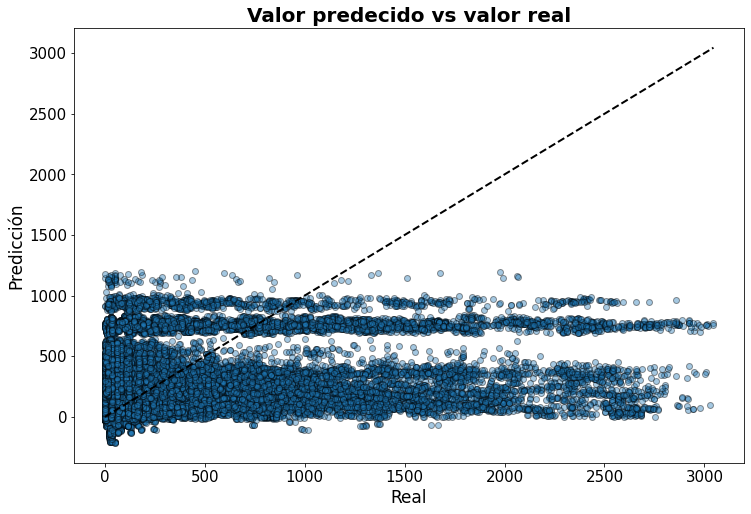

In [ ]:
fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

ax.scatter(y_valid, y_pred, edgecolors=(0, 0, 0), alpha = 0.4)
ax.plot([y_valid.min(), y_valid.max()], [y_valid.min(), y_valid.max()],
                'k--', color = 'black', lw=2)
ax.set_title('Valor predecido vs valor real', fontsize = 20, fontweight = "bold")
ax.set_xlabel('Real', fontsize=17)
ax.set_ylabel('Predicción', fontsize=17)
ax.tick_params(labelsize = 15)

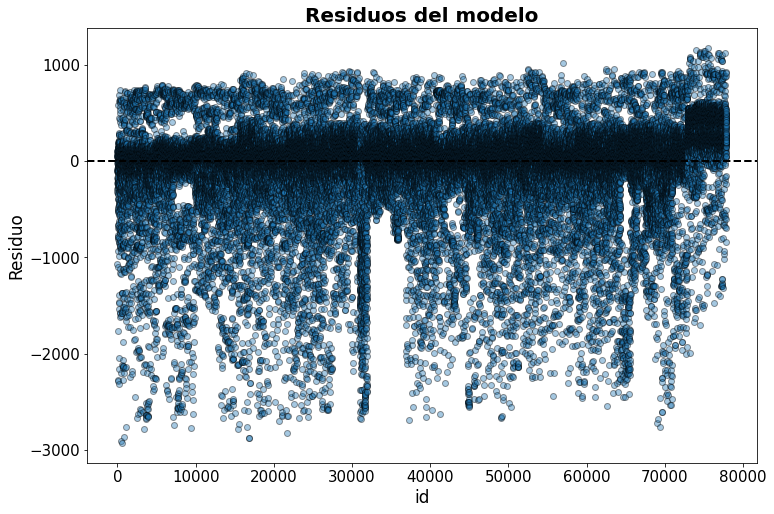

In [ ]:
fig2, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(12, 8))

residuos_train   = y_pred - y_valid

ax2.scatter(list(range(len(y_valid))), residuos_train,
                   edgecolors=(0, 0, 0), alpha = 0.4)
ax2.axhline(y = 0, linestyle = '--', color = 'black', lw=2)
ax2.set_title('Residuos del modelo', fontsize = 20, fontweight = "bold")
ax2.set_xlabel('id', fontsize=17)
ax2.set_ylabel('Residuo', fontsize=17)
ax2.tick_params(labelsize = 15)


# **VERSUS**

In [ ]:
downloaded = drive.CreateFile({'id': '12voIVKmM2EisPWQD8ickJot2nO5q1uv6'})
downloaded.GetContentFile('versus.csv')

In [ ]:
versus = pd.read_csv('versus.csv', encoding='latin-1')
versus["timestamp"]=pd.to_datetime(versus["timestamp"])
versus["timestamp"] = versus['timestamp'].dt.floor('d')

In [ ]:
versus.drop(['warnings', 'Type', 'Sales', 'Stock', 'price_unit'], axis = 1, inplace=True)
versus.rename(columns={'Category': 'category', 'From':'ships_from', 'price':'Price_EUR'}, inplace=True)
versus["Price_EUR"].replace({'EUR':''}, regex=True, inplace=True)
versus['Price_EUR'] = versus['Price_EUR'].astype(float)

In [ ]:
versus.head()

,title,category,ships_from,Price_EUR,timestamp
0,1oz. Distillate(FLAVORED),Concentrates,United States of America,115.96,2021-10-24
1,***3G for the price of 2G***,Cocaine,United Kingdom of Great Britain,70.91,2021-10-24
2,RAW THC DISTILLATE 1L (1000ml) $3 per gram Don...,Concentrates,United States of America,2576.90,2021-10-24
3,**Free** Colombian Coke Giveaway! 3.5G + 0.5G ...,Cocaine,United Kingdom of Great Britain,277.76,2021-10-24
4,***OPENING SALE 3.5G PURE CHAMPAGNE MDMA***,MDMA,United States of America,128.84,2021-10-24


Price NaNs?

In [ ]:
versus['Price_EUR'].isnull().values.sum()

0

Divido las fechas:

In [ ]:
versus['Year'] =  versus['timestamp'].dt.year 
versus['Month'] = versus['timestamp'].dt.month
versus['Day'] = versus['timestamp'].dt.day 

versus.drop('timestamp', axis=1, inplace=True)

NaNs?

In [ ]:
versus.fillna('Desconocido', inplace=True)

Aplico los encodings:

In [ ]:
versus.loc[~versus['ships_from'].isin(ships_from), 'ships_from'] = 'Otros'
ohe3 = pd.get_dummies(versus['ships_from'], prefix='From', drop_first = False, dummy_na = True)
versus.drop(['ships_from'], axis = 1, inplace = True)
versus = pd.concat([versus, ohe3], axis = 1)

In [ ]:
count_enc = ce.CountEncoder()
count_encoded = count_enc.fit_transform(versus['category'])
versus = versus.join(count_encoded.add_suffix("_count"))
versus.drop(['category'], axis=1, inplace=True)

In [ ]:
dfbin = encoder.fit_transform(versus['title'])
versus = pd.concat([versus, dfbin], axis = 1)
versus.drop('title', axis=1, inplace=True)

In [ ]:
versus.head()

,Price_EUR,Year,Month,Day,From_Australia,From_Belgium,From_Bulgaria,From_Canada,From_China,From_Czech Republic,From_France,From_Germany,From_India,From_Netherlands,From_Norway,From_Otros,From_Slovakia,From_South Africa,From_Spain,From_Sweden,From_Switzerland,From_nan,category_count,title_0,title_1,title_2,title_3,title_4,title_5,title_6,title_7,title_8,title_9,title_10,title_11,title_12,title_13
0,115.96,2021,10,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,436,0,0,0,0,0,0,0,0,0,0,0,0,0,1
1,70.91,2021,10,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1002,0,0,0,0,0,0,0,0,0,0,0,0,1,0
2,2576.90,2021,10,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,436,0,0,0,0,0,0,0,0,0,0,0,0,1,1
3,277.76,2021,10,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1002,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,128.84,2021,10,24,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,624,0,0,0,0,0,0,0,0,0,0,0,1,0,1


In [ ]:
x_test = versus.drop('Price_EUR', axis=1)
y_test = versus['Price_EUR']

x_test = x_test.reindex(labels=x_train.columns,axis=1)
x_test['title_14'] = 0

#Hay menos coincidas en la categoría "from" con respecto al train, por lo tanto se generan NaNs.
#Los relleno con 0
x_test.fillna(0, inplace=True)

In [ ]:
y_pred_test = lr_multiple.predict(x_test)

**Muy malo!:**

In [ ]:
mean_squared_error(y_test, y_pred_test)

72124634.75268224

In [ ]:
r2_score(y_test, y_pred_test)

-0.0019543464693874135